# **Algorithme d'Apprentissage Supervisé pour un Problème de Classification d'Images:**



## I. **Contexte et objectif de notre mini-projet :** 
### Nous allons former un modèle en PyTorch sur un datasat d'images pour classer les routes et les champs (classification binaire). Un des cas d'applications, une voiture autonome peut utiliser ce modèle pour distinguer les routes des champs et ainsi, éviter les champs et maintenir sa trajectoire  uniquement sur les routes.

##II. **CODE:**

# 1. libraries

In [1]:
%matplotlib inline
import os, math
import shutil
import numpy as np
import matplotlib.pyplot as plt
import torch
import torchvision
import torch.nn as nn 
import torch.optim as optim 
from torchvision import datasets, models, transforms
import time
import copy
plt.ion()   # interactive mode

# 2. Split data into a training set and a test set

In [2]:
# Création du dossier d'entraînement et de test, tels que chacun de ces deux dossiers contient 2 sous-dossiers 
# correspondants aux deux classes Route et Champ, initialement ces dossiers sont vides.  

data_dir = 'data_train_test'
subfolders = ['train', 'test']
classes = ['fields', 'roads']

try:
    os.makedirs(data_dir)
except OSError:
    if not os.path.isdir(data_dir):
        Raise
try:
    for i in range(2):
        os.makedirs(data_dir + '/' + subfolders[i])
        for j in range(2):
            os.makedirs(data_dir + '/' + subfolders[i] + '/' + classes[j])

except OSError:
    for i in range(2):
        if not os.path.isdir(data_dir + '/' + subfolders[i]):
            Raise
        else:
            for j in range(2):
                if not os.path.isdir(data_dir + '/' + subfolders[i] + '/' +
                                     classes[j]):
                    Raise

In [3]:
# Remplissage des classes (Route et Champs) du dossiers d'entrainement (resp test) avec 65% (resp 35%)
# des images du dossier initial "data" contenant toutes les images (90 images)

data_size = 45  # 45 images pour chaque classe
test_ratio = 35/100
test_size = int(data_size * test_ratio) #le dataset de test va contenir 35% des images
train_size = data_size - test_size #le dataset d'entrainement va contenir le reste (65% des images)

for i in range(2):
    for j in range(1, train_size+1):
        if os.path.exists(data_dir + '/' + subfolders[0] + '/' + classes[i] +
                          '/' + str(j) + '.jpg') is False:
            shutil.copy("data/" + classes[i] + '/' + str(j) + '.jpg',
                        data_dir + '/' + subfolders[0] + '/' + classes[i] +
                        '/' + str(j) + '.jpg')

    for j in range(train_size + 1, train_size + test_size + 1):
        if os.path.exists(data_dir + '/' + subfolders[1] + '/' + classes[i] +
                          '/' + str(j) + '.jpg') is False:
            shutil.copy("data/" + classes[i] + '/' + str(j) + '.jpg',
                        data_dir + '/' + subfolders[1] + '/' + classes[i] +
                        '/' + str(j) + '.jpg')

In [4]:
# Data augmentation and normalization for training
# Just normalization for test

data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'test': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}


data_dir = 'data_train_test'

image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),
                                          data_transforms[x])
                  for x in ['train', 'test']}

dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=4,
                                              shuffle=True, num_workers=4)
               for x in ['train', 'test']}

dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'test']}

class_names = image_datasets['train'].classes

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

/usr/local/lib/python3.8/dist-packages/torch/utils/data/dataloader.py:554: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


In [5]:
print (dataset_sizes)
print (class_names)
print (device)

{'train': 60, 'test': 30}
['fields', 'roads']
cuda:0


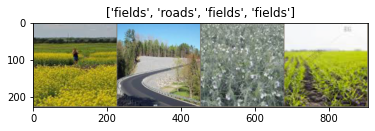

In [8]:
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean  # Reverse operation of normalization
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated


# Get a batch of training data
inputs, classes = next(iter(dataloaders['train']))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes])

# 3. Training the model


In [9]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    # For each EPOCH : Training + test phase
    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and test phase
        for phase in ['train', 'test']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                # Data To Device
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if phase = train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    # Loss
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # running statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data).cpu().numpy()
            if phase == 'train':
                scheduler.step()

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects / dataset_sizes[phase]

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))

            if phase == 'train':
                Losses_train.append(epoch_loss)
                Accu_train.append(epoch_acc)

            if phase == 'test':
                Losses_test.append(epoch_loss)
                Accu_test.append(epoch_acc)

            # deep copy the model
            if phase == 'test' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best test Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model

In [10]:
def visualize_model(model, num_images=6): #fonction d'affichage des predictions (6 exemples du test set)
    was_training = model.training
    model.eval()
    images_so_far = 0
    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders['test']):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')
                ax.set_title('predicted: {}'.format(class_names[preds[j]]))
                imshow(inputs.cpu().data[j])

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)

In [11]:
import torch.optim.lr_scheduler as lr_scheduler

model_conv = torchvision.models.resnet18(pretrained=True)
for param in model_conv.parameters():
    param.requires_grad = False ### paramètres du backbone resnet18 figés

# Parameters of newly constructed modules have requires_grad=True by default
num_ftrs = model_conv.fc.in_features
model_conv.fc = nn.Linear(num_ftrs, 2)

model_conv = model_conv.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that only parameters of final layer are being optimized as
# opposed to before.
optimizer_conv = optim.SGD(model_conv.fc.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_conv, step_size=7, gamma=0.1)

/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


  0%|          | 0.00/44.7M [00:00<?, ?B/s]

In [12]:
EPOCHS = 9
Losses_train = []
Losses_test = []
Accu_train = []
Accu_test = []

model_conv = train_model(model_conv, criterion, optimizer_conv,
                         exp_lr_scheduler, EPOCHS)

Epoch 0/8
----------
train Loss: 0.6531 Acc: 0.6000
test Loss: 0.3751 Acc: 0.9333

Epoch 1/8
----------
train Loss: 0.6740 Acc: 0.7000
test Loss: 0.7137 Acc: 0.5667

Epoch 2/8
----------
train Loss: 0.5232 Acc: 0.7833
test Loss: 0.1169 Acc: 0.9667

Epoch 3/8
----------
train Loss: 0.7093 Acc: 0.6833
test Loss: 0.2399 Acc: 0.8333

Epoch 4/8
----------
train Loss: 0.3784 Acc: 0.9000
test Loss: 0.0847 Acc: 0.9667

Epoch 5/8
----------
train Loss: 0.3095 Acc: 0.8833
test Loss: 0.0918 Acc: 0.9667

Epoch 6/8
----------
train Loss: 0.4348 Acc: 0.8667
test Loss: 0.0699 Acc: 1.0000

Epoch 7/8
----------
train Loss: 0.1782 Acc: 0.9667
test Loss: 0.0950 Acc: 0.9667

Epoch 8/8
----------
train Loss: 0.2616 Acc: 0.9000
test Loss: 0.0746 Acc: 0.9667

Training complete in 0m 17s
Best test Acc: 1.000000


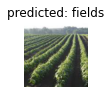

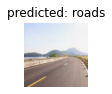

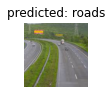

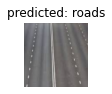

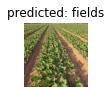

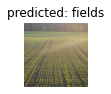

In [13]:
visualize_model(model_conv)

plt.ioff()
plt.show()

In [14]:
# Save model params in Drive
torch.save(model_conv.state_dict(), os.path.join(data_dir, 'Model_params'))

In [15]:
# Load model
model_conv.load_state_dict(torch.load(os.path.join(data_dir, 'Model_params')))
model_conv.eval()

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

# 4. Visualization of classification loss and accuracy  for both training and test data

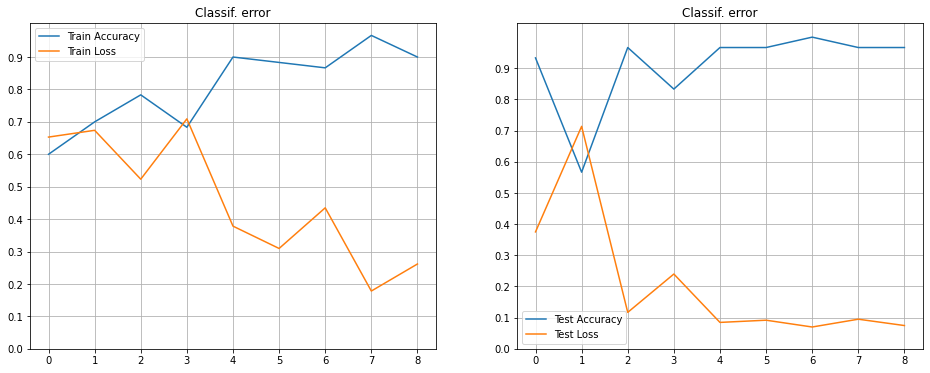

In [17]:
fig = plt.figure(figsize=(16, 6))
ax1 = fig.add_subplot(1, 2, 1)
plt.plot(Accu_train, label="Train Accuracy")
plt.plot(Losses_train, label="Train Loss")
plt.title('Classif. error')
ax1.set_xticks(np.arange(0, len(Losses_train), 1))
ax1.set_yticks(np.arange(0, max(Accu_train), 0.1))
plt.grid()
jnk = plt.legend()

ax2 = fig.add_subplot(1, 2, 2)
plt.plot(Accu_test, label="Test Accuracy")
plt.plot(Losses_test, label="Test Loss")
plt.title('Classif. error')
ax2.set_xticks(np.arange(0, len(Losses_test), 1))
ax2.set_yticks(np.arange(0, max(Accu_test), 0.1))
plt.grid()
jnk = plt.legend()